**Checking statistic of the Corpus**

In [7]:
import pandas as pd

df = pd.read_csv("data/un-general-debates-blueprint.csv.gz")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7507 entries, 0 to 7506
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   session       7507 non-null   int64 
 1   year          7507 non-null   int64 
 2   country       7507 non-null   object
 3   country_name  7507 non-null   object
 4   speaker       7480 non-null   object
 5   position      4502 non-null   object
 6   text          7507 non-null   object
dtypes: int64(2), object(5)
memory usage: 410.7+ KB


In [8]:
# Checking dataset with formatting issues.
print(repr(df.iloc[2666]["text"][0:200]))
print(repr(df.iloc[4729]["text"][0:200]))

'\ufeffIt is indeed a pleasure for me and the members of my delegation to extend to Ambassador Garba our sincere congratulations on his election to the presidency of the forty-fourth session of the General '
'\ufeffOn behalf of the State of Kuwait, it\ngives me pleasure to congratulate Mr. Han Seung-soo,\nand his friendly country, the Republic of Korea, on his\nelection as President of the fifty-sixth session of t'


In some speeches, the newline character is used to separate paragraphs. In others, it is used to separate lines.

In most cases, splitting at stops, exclamation points or question marks occuring at line ends works.

In [9]:
import re

df["paragraphs"] = df["text"].map(lambda text: re.split("[.?!]\s*\n", text))
df["number_of_paragraphs"] = df["paragraphs"].map(len)

<AxesSubplot:xlabel='year'>

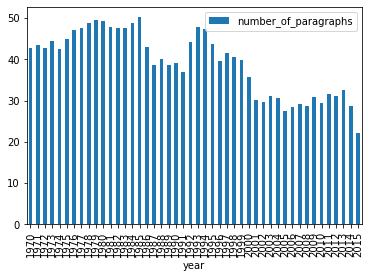

In [10]:
%matplotlib inline

df.groupby("year").agg({"number_of_paragraphs": "mean"}).plot.bar()

**Preparations**

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stop_words

In [17]:
tfidf_text = TfidfVectorizer(stop_words=stop_words, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text.fit_transform(df["text"])
tfidf_text_vectors.shape

(7507, 24611)

In [14]:
# Flatten the paragraphs keeping the years.
paragraph_df = pd.DataFrame(
    [
        {"text": paragraph, "year": year}
        for paragraphs, year in zip(df["paragraphs"], df["year"])
        for paragraph in paragraphs
        if paragraph
    ]
)
tfidf_para_vectorizer = TfidfVectorizer(stop_words=stop_words, min_df=5, max_df=0.7)
tfidf_para_vectors = tfidf_para_vectorizer.fit_transform(paragraph_df["text"])
tfidf_para_vectors.shape

(282210, 25165)

### Nonnegative Matrix Factorization (NMF)

$$V = W{\cdot}H$$

### Blueprint: Creating a Topic Model using NMF for Documents

In [19]:
from sklearn.decomposition import NMF

nmf_text_model = NMF(n_components=10, random_state=42)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

/usr/local/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/usr/local/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [23]:
def display_topics(model, features, no_top_words=5):
    for topic, word_vector in enumerate(model.components_):
        total = word_vector.sum()
        largest = word_vector.argsort()[::-1]  # Invert sort order
        print(f"\nTopic {topic:02d}")
        for i in range(no_top_words):
            print(
                "  {} ({:.2f})".format(
                    features[largest[i]], word_vector[largest[i]] * 100.0 / total
                )
            )

In [24]:
display_topics(nmf_text_model, tfidf_text.get_feature_names())


Topic 00
  co (0.79)
  operation (0.65)
  disarmament (0.36)
  nuclear (0.34)
  relations (0.25)

Topic 01
  terrorism (0.38)
  challenges (0.32)
  sustainable (0.30)
  millennium (0.29)
  reform (0.28)

Topic 02
  africa (1.15)
  african (0.82)
  south (0.63)
  namibia (0.36)
  delegation (0.30)

Topic 03
  arab (1.02)
  israel (0.89)
  palestinian (0.60)
  lebanon (0.54)
  israeli (0.54)

Topic 04
  american (0.33)
  america (0.31)
  latin (0.31)
  panama (0.21)
  bolivia (0.21)

Topic 05
  pacific (1.55)
  islands (1.23)
  solomon (0.86)
  island (0.82)
  fiji (0.71)

Topic 06
  soviet (0.81)
  republic (0.78)
  nuclear (0.68)
  viet (0.64)
  socialist (0.63)

Topic 07
  guinea (4.26)
  equatorial (1.75)
  bissau (1.53)
  papua (1.47)
  republic (0.57)

Topic 08
  european (0.61)
  europe (0.44)
  cooperation (0.39)
  bosnia (0.34)
  herzegovina (0.30)

Topic 09
  caribbean (0.98)
  small (0.66)
  bahamas (0.63)
  saint (0.63)
  barbados (0.61)


**Finding how "big" a topic is**

In [25]:
# Sum all rows.
W_text_matrix.sum(axis=0) / W_text_matrix.sum() * 100.0

array([11.14353588, 17.10877242, 13.61965772, 10.16345439, 11.41042599,
        5.93353622,  7.86636069,  4.13893748, 11.84152198,  6.77379723])

### Blueprint: Creating a Topic Model for Paragraphs using NMF

In [ ]:
nmf_para_model = NMF(n_components=10, random_state=42)
W_para_matrix = nmf_para_model.fit_transform(tfidf_para_vectors)
H_para_matrix = nmf_para_model.components_

In [ ]:
display_topics(nmf_para_model, tfidf_para_vectorizer.get_feature_names())

## Latent Semantic Analysis/Indexing